<a href="https://colab.research.google.com/github/rahaft/GoJS/blob/master/DogVision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)

print("GPU is", "available!!!!! " if tf.config.list_physical_devices("GPU") else "not available :-()")

#If GPU not avaialble go to Runtime > Change runtime time. Choose Python 3 > Hardware: one of the GPUs. Wait for Ram / Disk to change and rerun

TF version: 2.19.0
Hub version: 0.16.1
GPU is available!!!!! 


# Working with Data

## Unzip files

In [64]:
#Unzip data if needed
#!unzip "/content/drive/MyDrive/ZeroToMastery/dog-breed-identification.zip" -d "/content/drive/MyDrive/ZeroToMastery/DogVision/"

#!mkdir -p "/content/drive/MyDrive/ZeroToMastery/ISCI-2024-Challenge/train-image"
#!mkdir -p "/content/drive/MyDrive/ZeroToMastery/ISCI-2024-Challenge/train-metadata"

#!unzip "/content/drive/MyDrive/isic-2024-challenge/train-metadata.csv.zip" -d "/content/drive/MyDrive/ZeroToMastery/ISCI-2024-Challenge/train-metadata/"

#!unzip "/content/drive/MyDrive/isic-2024-challenge/train-image.zip" -d "/content/drive/MyDrive/ZeroToMastery/ISCI-2024-Challenge/train-image/"
#!unzip "/content/drive/MyDrive/isic-2024-challenge/train-metadata.csv.zip" -d "/content/drive/MyDrive/ZeroToMastery/ISCI-2024-Challenge/train-metadata/"

----
## Set which data set we are working with

* Set 1 - DogVision
* Set 2 - ISCI - Lower quality images - https://www.kaggle.com/competitions/isic-2024-challenge/


In [65]:
set_num = 1

In [66]:
if set_num == 1:
  experiment_title = "DogVision: "
elif set_num == 2:
    experiment_title = "ISCI: "

###########################

image_type_num = 1
split_index = .8  # To give 100% of your data to the training set, you set the validation portion to zero.

NUM_IMAGES = 1000 #@param {type:"slider",min:1000,max:10000, step:1000} #SEt number of images to use for experimenting

image_type = "other"  # will change direclty bleow this to pad, stretch, crop

if image_type_num == 1:
   # Maintains aspect ratio, fills gaps with black
  image_type = "pad"
elif image_type_num == 2:
      # Forces image into square, can distort lesion shape
    image_type ="stretch"

elif image_type_num == 3:
       # Resizes and crops to maintain aspect ratio without padding
    image_type == "crop"


## Getting our data ready(turning it into Tensors)
With all machine learning models, our data needs to be turned into numerical format. So that is what needs to be done first. This is turning our images into Tensors (numerical representations)

###Step 1: Access data and check labels

In [67]:
from google.colab import drive

drive.mount('/content/drive')
if set_num == 1:
  labels_csv = pd.read_csv("/content/drive/MyDrive/ZeroToMastery/DogVision/labels.csv")
elif set_num == 2:
  path = "/content/drive/MyDrive/ZeroToMastery/ISCI-2024-Challenge/train-metadata/train-metadata.csv"
  labels_csv = pd.read_csv(path)

############################

print(labels_csv.describe())
print(labels_csv.head())
#alternative view
#labels_csv.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                                      id               breed
count                              10222               10222
unique                             10222                 120
top     fff43b07992508bc822f33d8ffd902ae  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [68]:
if set_num == 1:
  # How many are there of each breed?
  labels_csv["breed"].value_counts()


In [69]:
if set_num == 2:
  # 1. Define the features we want to calculate based on ABCDE
  columns = [
    'isic_id',           # Unique identifier for the image
    'asymmetry_score',   # A: 0 to 2 scale
    'border_score',      # B: 0 to 8 scale
    'color_count',       # C: Number of colors detected
    'diameter_mm',       # D: Calculated from metadata
    'target'             # The actual label (0=benign, 1=malignant)
  ]

  # 2. Create the empty DataFrame
  abcde_results = pd.DataFrame(columns=columns)

  # 3. (Optional) Pre-fill the isic_id and target from your main CSV
  # This ensures your new table is perfectly aligned with your labels
  abcde_results['isic_id'] = labels_csv['isic_id']
  abcde_results['target'] = labels_csv['target']

  # Display the first few rows of your new tracking table
  print("Calculation Table Created:")
  print(abcde_results.head())



## Check to see if we have the minimum number to train

Ideally there are 100 annotations per labels. At least 10 is a good start.

In [70]:
if set_num == 1:
  #float(labels_csv["breed"].value_counts().mean())
  avg_breed = labels_csv["breed"].value_counts().mean()
  print(f"The average number of images per breed is: {avg_breed:.2f}")

  median_breed = labels_csv["breed"].value_counts().median()
  print(f"The average number of images per breed is: {median_breed:.2f}")
elif set_num == 2:
  avg_diag = labels_csv["iddx_1"].value_counts().mean()
  print(f"The diagnoses is iddx_1: {avg_diag:.2f}")

  median_diag= labels_csv["iddx_1"].value_counts().median()
  print(f"The average number of images per diagnosis is: {median_diag:.2f}")

  median_diag = labels_csv["iddx_full"].value_counts().median()
  print(f"The average number of images per detailed diagnosis is: {median_diag:.2f}")




The average number of images per breed is: 85.18
The average number of images per breed is: 82.00


In [71]:
import pandas as pd

def get_diagnosis_summary(df):
    """
    Prints a detailed summary of counts and percentages
    for both broad and detailed diagnoses.
    """
    for col in ['iddx_1', 'iddx_full']:
        print(f"\n{'='*10} Summary for {col} {'='*10}")

        # Calculate raw counts and percentages
        counts = df[col].value_counts()
        percent = df[col].value_counts(normalize=True) * 100

        # Combine into a summary table
        summary = pd.DataFrame({
            'Count': counts,
            'Percentage (%)': percent.round(2)
        })

        print(summary)

        # Metrics for your "Exact vs Experimental" testing
        print(f"\nTotal Unique Labels in {col}: {len(counts)}")
        print(f"Labels with < 10 images: {(counts < 10).sum()}")
        print(f"Median count per label: {counts.median()}")

# Run the function

if set_num == 2:
  get_diagnosis_summary(labels_csv)

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_diagnosis_distributions(df):
    """
    Plots the frequency of both general (iddx_1) and
    detailed (iddx_full) diagnoses.
    """
    # Set the style for scientific clarity
    sns.set_theme(style="whitegrid")
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    # 1. Plot General Diagnosis (iddx_1)
    # Using log scale to handle the 133k+ count
    iddx1_order = df['iddx_1'].value_counts().index
    sns.countplot(data=df, y='iddx_1', order=iddx1_order, ax=axes[0], palette='viridis')
    axes[0].set_xscale("log")
    axes[0].set_title('General Diagnosis (iddx_1) - Log Scale', fontsize=14)
    axes[0].set_xlabel('Count (Logarithmic)')
    axes[0].set_ylabel('Diagnosis Label')

    # 2. Plot Detailed Diagnosis (iddx_full)
    # We take the top 30 to keep the graph readable,
    # as there are many rare diagnoses.
    iddxfull_counts = df['iddx_full'].value_counts()
    top_30_iddxfull = iddxfull_counts.iloc[:30].index

    sns.barplot(x=iddxfull_counts.loc[top_30_iddxfull].values,
                y=top_30_iddxfull,
                ax=axes[1],
                palette='magma')
    axes[1].set_title('Top 30 Detailed Diagnoses (iddx_full)', fontsize=14)
    axes[1].set_xlabel('Count')
    axes[1].set_ylabel('Detailed Label')

    plt.tight_layout()
    plt.show()

# To use this in your main pipeline:
# plot_diagnosis_distributions(labels_csv)

if set_num == 2:
  plot_diagnosis_distributions(labels_csv)

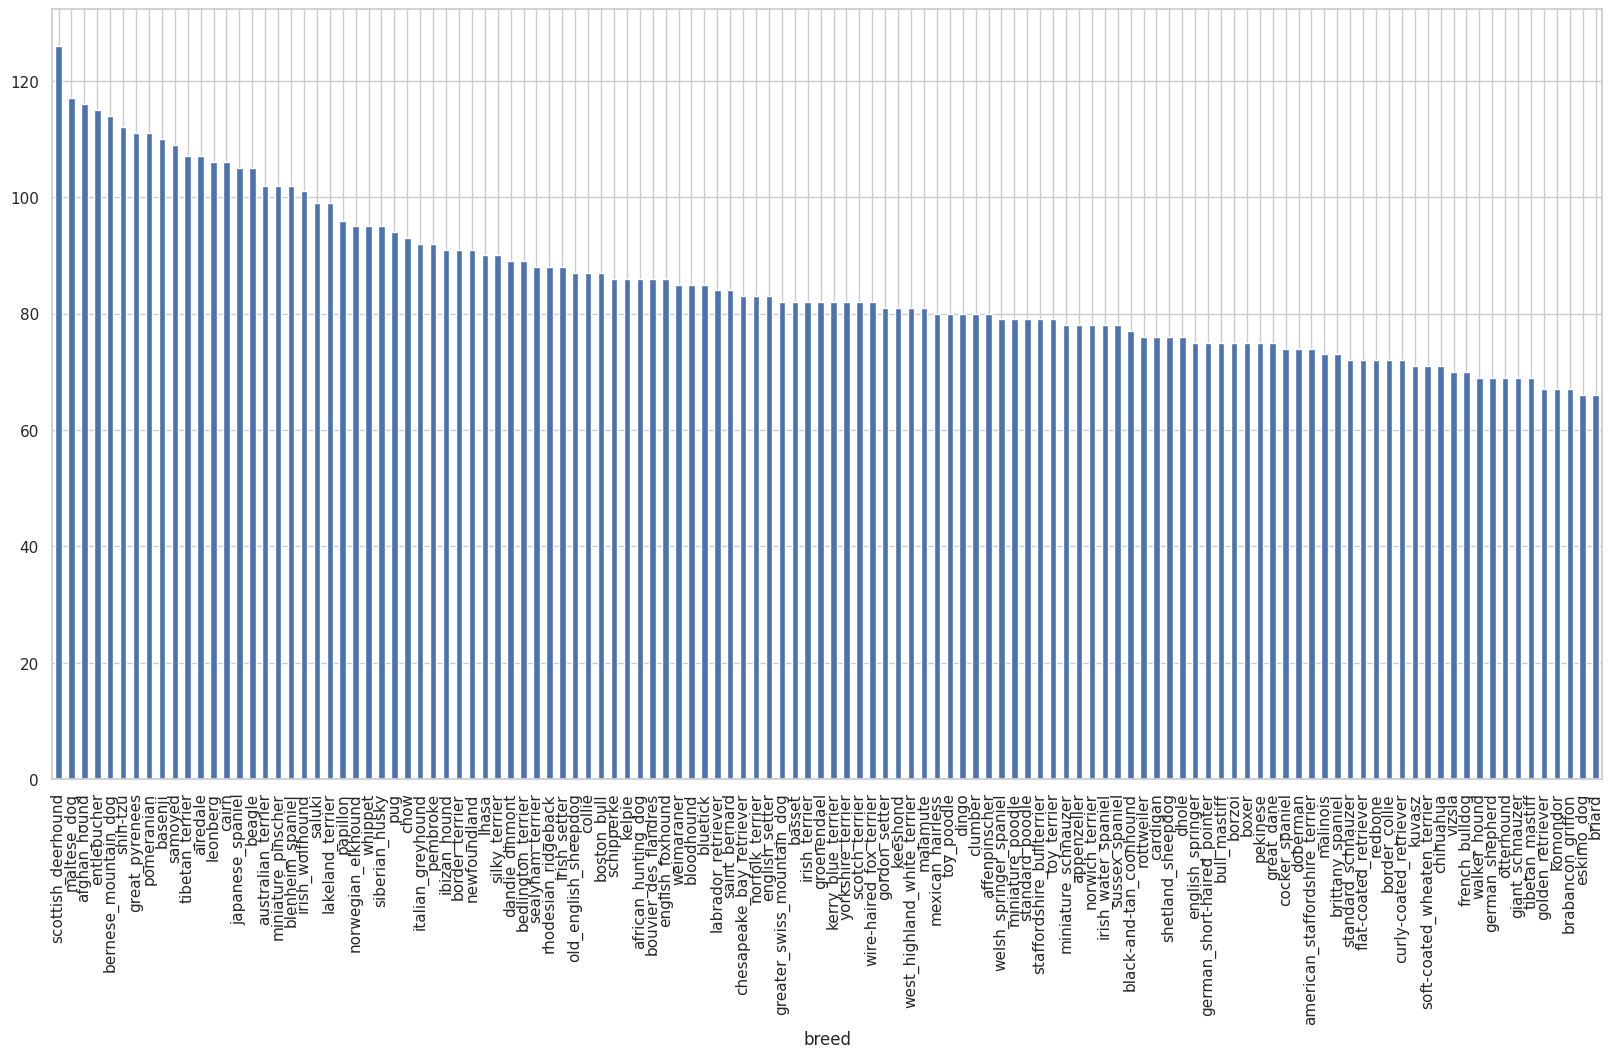

In [73]:
if set_num == 1:
  labels_csv["breed"].value_counts().plot.bar(figsize=(20,10))
elif set_num == 2:
  labels_csv["iddx_1"].value_counts().plot.bar(figsize=(20,10))

In [74]:
# Try to view an image

if set_num == 2:
  from IPython.display import Image
  image_path_url = "/content/drive/MyDrive/ZeroToMastery/ISCI-2024-Challenge/train-image/image/"
  Image("/content/drive/MyDrive/ZeroToMastery/ISCI-2024-Challenge/train-image/image/ISIC_2637405.jpg")

### Getting images and their labels

Let's get a list of all our image files

In [75]:
# Create pathname from image IDs
if set_num == 1:
  filename= ["/content/drive/MyDrive/ZeroToMastery/DogVision/train/" + fname +".jpg" for fname in labels_csv["id"]]
  # Check the first one
  filename[0]
  filename0= [fname for fname in labels_csv["id"]]
  filename0[0]
elif set_num == 2:
  filename= ["/content/drive/MyDrive/ZeroToMastery/ISCI-2024-Challenge/train-image/image/" + fname +".jpg" for fname in labels_csv["isic_id"]]
  filename0= [fname for fname in labels_csv["isic_id"]]

 # Check the first one
print(f"Total files: {len(filename)}")
file_num = 1
print(f"First path: {filename[file_num]}")
print(f"First path: {filename0[file_num]}")

if set_num == 2:
  # Display the image and its exact metadata from the same row
  from IPython.display import Image
  print(f"Grouped Diagnosis: {labels_csv['isic_id'].iloc[file_num]}")
  print(f"Grouped Diagnosis: {labels_csv['iddx_1'].iloc[file_num]}")
  print(f"Detailed Diagnosis: {labels_csv['iddx_full'].iloc[file_num]}")
  display(Image(filename[file_num]))




Total files: 10222
First path: /content/drive/MyDrive/ZeroToMastery/DogVision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg
First path: 001513dfcb2ffafc82cccf4d8bbaba97


In [76]:
# Check whether number of filenames matches number of actual images
import os

if set_num == 1:
  if len(os.listdir("/content/drive/MyDrive/ZeroToMastery/DogVision/train"))==len(filename):
    print("Filenames match actual image count")
  else:
    print("Filenames do not match actual image count")
elif set_num == 2:
  if len(os.listdir("/content/drive/MyDrive/ZeroToMastery/ISCI-2024-Challenge/train-image/image"))==len(filename):
    print("✅ Filenames match actual image count")
  else:
    print("❌ Filenames do not match actual image count")

Filenames match actual image count


9106
Path 1: /content/drive/MyDrive/ZeroToMastery/DogVision/train/e4f4ecefab54cba3356b0c8bf7ce4fee.jpg
Path 2: e4f4ecefab54cba3356b0c8bf7ce4fee
Breed: bernese_mountain_dog


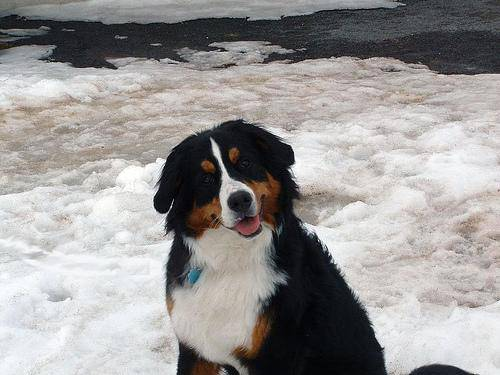

In [77]:
# Check random image to make sure working
import random

# Generate a random index between 0 and the end of your filename list
random_index = random.randint(0, len(filename0) - 1)

print(random_index)

if set_num == 1:
  labels_csv["id"][random_index]
elif set_num == 2:
  labels_csv["isic_id"][random_index]
print(f"Path 1: {filename[random_index]}")
print(f"Path 2: {filename0[random_index]}")

if set_num == 1:
  print(f"Breed: {labels_csv["breed"][random_index]}")
elif set_num == 2:
   print(f"Diagnosis: {labels_csv["iddx_1"][random_index]}")
#filename0[random_index]
Image(filename[random_index])

## Turning Data Labels Into Numbers

In [78]:
# Now we have our training image filepaths and now we needlabels
if set_num == 1:
  labels = labels_csv["breed"]
elif set_num == 2:
  labels = labels_csv["iddx_1"]

labels = np.array(labels)
print(f"Length of labels: {len(labels)}")
print(f"Labels: {(labels)}")

if len(labels) == len(filename):
  print("Number of labels matches number of filenames!")
else:
  print("Number of labels does not match number of filenames, check data directories")

Length of labels: 10222
Labels: ['boston_bull' 'dingo' 'pekinese' ... 'airedale' 'miniature_pinscher'
 'chesapeake_bay_retriever']
Number of labels matches number of filenames!


In [79]:
unique_breeds = np.unique(labels)
if set_num == 1:
  print(f"Number of unique breeds: {len(unique_breeds)}")
  print(f"")
  print(f"Unique breeds: {(unique_breeds)}")
elif set_num == 2:
  print(f"Number of unique diagnoses: {len(unique_breeds)}")
  print(f"")
  print(f"Unique diagnoses: {(unique_breeds)}")


Number of unique breeds: 120

Unique breeds: ['affenpinscher' 'afghan_hound' 'african_hunting_dog' 'airedale'
 'american_staffordshire_terrier' 'appenzeller' 'australian_terrier'
 'basenji' 'basset' 'beagle' 'bedlington_terrier' 'bernese_mountain_dog'
 'black-and-tan_coonhound' 'blenheim_spaniel' 'bloodhound' 'bluetick'
 'border_collie' 'border_terrier' 'borzoi' 'boston_bull'
 'bouvier_des_flandres' 'boxer' 'brabancon_griffon' 'briard'
 'brittany_spaniel' 'bull_mastiff' 'cairn' 'cardigan'
 'chesapeake_bay_retriever' 'chihuahua' 'chow' 'clumber' 'cocker_spaniel'
 'collie' 'curly-coated_retriever' 'dandie_dinmont' 'dhole' 'dingo'
 'doberman' 'english_foxhound' 'english_setter' 'english_springer'
 'entlebucher' 'eskimo_dog' 'flat-coated_retriever' 'french_bulldog'
 'german_shepherd' 'german_short-haired_pointer' 'giant_schnauzer'
 'golden_retriever' 'gordon_setter' 'great_dane' 'great_pyrenees'
 'greater_swiss_mountain_dog' 'groenendael' 'ibizan_hound' 'irish_setter'
 'irish_terrier' 'iri

In [80]:
# Turn single label into an array of booleans where everywhere there is a unique breeds but where it does equal it is true
if set_num == 1:
  print(labels[0])
  labels[0] == unique_breeds

boston_bull


In [81]:
if set_num == 1:
  # Turn every label into a boolean array
  #boolean_labels = [label == np.array(unique_breeds) for label in labels]
  boolean_labels = [label == unique_breeds for label in labels]
  boolean_labels[:2]


In [82]:
if set_num == 1:
  len(boolean_labels)

In [83]:
#Exaample Turning boolean array into integers
if set_num == 1:
  print(labels[0]) # Original label
  print(np.where(unique_breeds==labels[0]))  #index where label occurs
  print(boolean_labels[0].argmax()) #index where label occurs in boolean array
  print(boolean_labels[0].astype(int)) # There will be a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [85]:

import matplotlib.pyplot as plt
import cv2
import random

def display_25_malignant(df, img_dir):
    # 1. Filter for Malignant cases only
    malignant_df = df[df["iddx_1"] == "Malignant"]

    # 2. Select 25 random samples (or all if less than 25)
    n_samples = min(25, len(malignant_df))
    sample_df = malignant_df.sample(n_samples)

    # 3. Setup the 5x5 Grid
    plt.figure(figsize=(20, 20))

    for i, (idx, row) in enumerate(sample_df.iterrows()):
        plt.subplot(5, 5, i + 1)

        # Build path using the correct isic_id key
        img_path = f"{img_dir}{row['isic_id']}.jpg"

        try:
            # Load and convert to RGB for Matplotlib
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow(img)

            # Display exact metadata labels
            plt.title(f"ID: {row['isic_id']}\n{row['iddx_full']}\n{row['clin_size_long_diam_mm']}mm", fontsize=10)
        except Exception as e:
            plt.title(f"Error loading {row['isic_id']}")

        plt.axis('off')

    plt.tight_layout()
    plt.show()


if set_num == 2:
  # --- RUN THE SCRIPT ---
  # Ensure your directory path ends with a slash
  train_dir = "/content/drive/MyDrive/ZeroToMastery/ISCI-2024-Challenge/train-image/image/"
  display_25_malignant(labels_csv, train_dir)

In [86]:
import matplotlib.pyplot as plt
import cv2
import random

def display_25_benign(df, img_dir, size_threshold=1.0):
    # 1. Filter for Benign cases > 1mm
    benign_df = df[
        (df["iddx_1"] == "Benign") &
        (df["clin_size_long_diam_mm"] > size_threshold)
    ]

    # 2. Select 25 random samples
    n_samples = min(25, len(benign_df))
    sample_df = benign_df.sample(n_samples)

    # 3. Setup the 5x5 Grid
    plt.figure(figsize=(20, 20))

    for i, (idx, row) in enumerate(sample_df.iterrows()):
        plt.subplot(5, 5, i + 1)

        # Build path using the correct isic_id key
        img_path = f"{img_dir}{row['isic_id']}.jpg"

        try:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow(img)

            # Display exact metadata labels
            plt.title(f"ID: {row['isic_id']}\n{row['iddx_full']}\n{row['clin_size_long_diam_mm']}mm", fontsize=10)
        except Exception as e:
            plt.title(f"Error loading {row['isic_id']}")

        plt.axis('off')

    plt.tight_layout()
    plt.show()

if set_num == 2:
  # --- RUN THE SCRIPT ---
  train_dir = "/content/drive/MyDrive/ZeroToMastery/ISCI-2024-Challenge/train-image/image/"
  display_25_benign(labels_csv, train_dir)

In [87]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def get_lesion_only(img):
    """
    Creates a mask and removes the skin background.
    """
    # Use the Red channel for better differentiation in skin imaging
    red_channel = img[:, :, 0]

    # Simple thresholding to isolate the dark lesion from lighter skin
    _, mask = cv2.threshold(red_channel, 100, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Apply the mask to the original image
    lesion_only = cv2.bitwise_and(img, img, mask=mask)
    return lesion_only, mask

def run_background_test(df, img_dir, diagnosis, n_samples=25):
    subset = df[df["iddx_1"] == diagnosis].sample(n_samples)

    # We will display them in rows: [Original | Background Removed]
    fig, axes = plt.subplots(n_samples, 2, figsize=(10, 4 * n_samples))

    for i, (idx, row) in enumerate(subset.iterrows()):
        img_path = f"{img_dir}{row['isic_id']}.jpg"
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Remove background
        effected_area, _ = get_lesion_only(img)

        # Display
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f"Original: {row['isic_id']}")
        axes[i, 1].imshow(effected_area)
        axes[i, 1].set_title(f"Effected Area Only ({row['iddx_full']})")

        for ax in axes[i]: ax.axis('off')

    plt.tight_layout()
    plt.show()

if set_num == 2:
  # --- RUN FOR BOTH ---
  run_background_test(labels_csv, train_dir, "Malignant")
  run_background_test(labels_csv, train_dir, "Benign")

In [88]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def get_symmetry_scores(img, mask):
    """
    Calculates symmetry for both the binary shape and the visual image.
    """
    # 1. Mask Symmetry (Binary XOR)
    h_flip_m = cv2.flip(mask, 1)
    v_flip_m = cv2.flip(mask, 0)

    mask_score = (np.sum(cv2.bitwise_xor(mask, h_flip_m)) +
                  np.sum(cv2.bitwise_xor(mask, v_flip_m))) / (2 * np.sum(mask))

    # 2. Visual Symmetry (Pixel Intensity Difference)
    # We use a grayscale version of the original image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    h_flip_g = cv2.flip(gray, 1)
    v_flip_g = cv2.flip(gray, 0)

    # Calculate Mean Absolute Error (MAE) for visual pixels
    visual_score = (np.mean(np.abs(gray - h_flip_g)) +
                    np.mean(np.abs(gray - v_flip_g))) / 2

    return mask_score, visual_score

def run_dual_symmetry_test(df, img_dir, diagnosis, n_samples=25):
    subset = df[df["iddx_1"] == diagnosis].sample(n_samples)
    results = []

    for i, (idx, row) in enumerate(subset.iterrows()):
        img_path = f"{img_dir}{row['isic_id']}.jpg"
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Isolate lesion for the 'Mask' qualifier
        red_channel = img[:, :, 0]
        _, mask = cv2.threshold(red_channel, 100, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

        # Get both scores
        m_score, v_score = get_symmetry_scores(img, mask)
        results.append({'id': row['isic_id'], 'mask_sym': m_score, 'visual_sym': v_score})

    return pd.DataFrame(results)

if set_num == 2:
  # --- EXECUTE ---
  sym_malignant = run_dual_symmetry_test(labels_csv, train_dir, "Malignant")
  sym_benign = run_dual_symmetry_test(labels_csv, train_dir, "Benign")

In [90]:
if set_num == 2:
  import seaborn as sns
  import matplotlib.pyplot as plt

  # Combine the results for easy plotting
  sym_malignant['diagnosis'] = 'Malignant'
  sym_benign['diagnosis'] = 'Benign'
  combined_results = pd.concat([sym_malignant, sym_benign])

  # Create the visual distribution
  plt.figure(figsize=(12, 6))

  # Plotting the Mask Symmetry (The "Effected Area" Shape)
  sns.kdeplot(data=combined_results, x="mask_sym", hue="diagnosis",
            fill=True, palette={'Malignant': 'red', 'Benign': 'green'}, alpha=0.5)

  plt.title("Distribution of Mask Symmetry: Malignant vs. Benign", fontsize=15)
  plt.xlabel("Asymmetry Score (Higher = More Asymmetrical)")
  plt.ylabel("Density")
  plt.grid(axis='y', alpha=0.3)
  plt.show()

In [91]:
if set_num == 2:
  # Create a comparison of Shape vs. Visual Symmetry
  plt.figure(figsize=(14, 6))

  # Plot 1: Shape Symmetry (Background Removed)
  plt.subplot(1, 2, 1)
  sns.kdeplot(data=combined_results, x="mask_sym", hue="diagnosis", fill=True)
  plt.title("Shape Symmetry\n(Background Removed)")

  # Plot 2: Visual Symmetry (Regular Image)
  plt.subplot(1, 2, 2)
  sns.kdeplot(data=combined_results, x="visual_sym", hue="diagnosis", fill=True)
  plt.title("Visual Symmetry\n(Regular Image)")

  plt.tight_layout()
  plt.show()

In [92]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def get_border_irregularity(img):
    """
    Finds the lesion border and calculates the irregularity score.
    """
    # 1. Create a mask to find the 'Exact' edge
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, mask = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # 2. Find Contours (The Border)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return img, 0.0

    # Get the largest contour (the lesion)
    cnt = max(contours, key=cv2.contourArea)
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt, True)

    # 3. Calculate Irregularity Score (Compactness)
    # Formula: (Perimeter^2) / (4 * PI * Area)
    # A perfect circle = 1.0. Irregular borders > 1.0.
    if area > 0:
        irreg_score = (perimeter**2) / (4 * np.pi * area)
    else:
        irreg_score = 0

    # 4. Draw the border outline on the original image
    outlined_img = img.copy()
    cv2.drawContours(outlined_img, [cnt], -1, (0, 255, 0), 2) # Green outline

    return outlined_img, irreg_score

def display_border_test(df, img_dir, diagnosis, n_samples=25):
    subset = df[df["iddx_1"] == diagnosis].sample(n_samples)
    plt.figure(figsize=(20, 20))

    for i, (idx, row) in enumerate(subset.iterrows()):
        plt.subplot(5, 5, i + 1)

        # Load and process
        img_path = f"{img_dir}{row['isic_id']}.jpg"
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        outlined, score = get_border_irregularity(img)

        plt.imshow(outlined)
        plt.title(f"ID: {row['isic_id']}\nScore: {score:.2f}", fontsize=10)
        plt.axis('off')

    plt.suptitle(f"Border Irregularity: {diagnosis} (Green = Exact Border)", fontsize=20)
    plt.tight_layout()
    plt.show()

if set_num == 2:
  # --- EXECUTE ---
  display_border_test(labels_csv, train_dir, "Malignant")
  #

In [93]:
if set_num == 2:
  display_border_test(labels_csv, train_dir, "Benign")

In [94]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def analyze_symmetry_with_values(image_path, mask):
    """
    Quantifies symmetry and displays exact values alongside the visual report.
    """
    # 1. Prepare Mask (Source of Truth)
    mask = (mask > 0).astype(np.uint8)
    total_area = np.sum(mask)

    # 2. Geometric XOR Fold (Mask Symmetry)
    h_flip = cv2.flip(mask, 1)
    v_flip = cv2.flip(mask, 0)
    diff_h = cv2.bitwise_xor(mask, h_flip)
    diff_v = cv2.bitwise_xor(mask, v_flip)

    # Calculate Exact Mask Score (0.0 = perfect symmetry)
    mask_score = (np.sum(diff_h) + np.sum(diff_v)) / (2 * total_area)

    # 3. Print the Exact Values for this Image
    print(f"--- Symmetry Values for {image_path.split('/')[-1]} ---")
    print(f"Exact Mask Symmetry (Shape): {mask_score:.4f}")

    # Return score for our distribution plot
    return mask_score

if set_num == 2:
  # Example for a single check
  current_score = analyze_symmetry_with_values(filename[file_num], current_mask)

---
## Executing on pre-processing of images

In [95]:
if set_num == 2:
  malignant_df = labels_csv[labels_csv["iddx_1"] == "Malignant"]

  # Find the minimum 'exact' diameter
  smallest_size = malignant_df["clin_size_long_diam_mm"].min()

  # FIX: Change "is_isic_id" to "isic_id"
  smallest_id = malignant_df.loc[malignant_df["clin_size_long_diam_mm"].idxmin(), "isic_id"]

  print(f"The smallest Malignant lesion is {smallest_size} mm.")
  print(f"ISIC ID of smallest lesion: {smallest_id}")

In [96]:
if set_num == 2:
  import matplotlib.pyplot as plt
  import seaborn as sns
  import numpy as np

  # 1. Correctly Filter and Setup (Fixes your KeyError)
  malignant_df = labels_csv[labels_csv["iddx_1"] == "Malignant"].copy()
  size_col = "clin_size_long_diam_mm"

  # Stats for the titles
  min_s = malignant_df[size_col].min()
  max_s = malignant_df[size_col].max()
  mean_s = malignant_df[size_col].mean()

  # --- GRAPH 1: Size Distribution ---
  plt.figure(figsize=(12, 6))

  # Histogram with KDE
  sns.histplot(malignant_df[size_col], kde=True, color='crimson', bins=30)
  plt.axvline(mean_s, color='blue', linestyle='--', label=f'Mean: {mean_s:.2f}mm')
  plt.axvline(np.median(malignant_df[size_col]), color='green', linestyle='-', label='Median')

  plt.title(f'Size Distribution of Malignant Tumors (N=393)\nRange: {min_s}mm to {max_s}mm', fontsize=15)
  plt.xlabel('Longest Diameter (mm)', fontsize=12)
  plt.ylabel('Frequency', fontsize=12)
  plt.legend()
  plt.grid(axis='y', alpha=0.3)
  plt.show()

  # --- GRAPH 2: Box Plot (Outlier Analysis) ---
  plt.figure(figsize=(10, 4))
  sns.boxplot(x=malignant_df[size_col], color='lightcoral')
  plt.title('Malignant Size Range & Outliers', fontsize=14)
  plt.xlabel('Diameter (mm)')
  plt.show()

  # --- GRAPH 3: Physical Scale Comparison ---
  # This visualizes circles to show the real physical scale of the tumors
  fig, ax = plt.subplots(figsize=(10, 4))
  circle_sizes = [min_s, mean_s, max_s]
  labels = [f"Smallest\n({min_s}mm)", f"Average\n({mean_s:.1f}mm)", f"Largest\n({max_s}mm)"]
  positions = [2, 10, 30]

  for s, p, l in zip(circle_sizes, positions, labels):
    circle = plt.Circle((p, 2), s/2, color='darkred', alpha=0.6)
    ax.add_patch(circle)
    ax.text(p, 2 - (s/2) - 1, l, ha='center', fontweight='bold')

  ax.set_xlim(0, 50)
  ax.set_ylim(0, 5)
  ax.set_aspect('equal')
  ax.axis('off')
  plt.title("Physical Size Comparison (to scale)", fontsize=14)
  plt.show()

In [97]:
if set_num == 2:
  # 1. Identify the size column
  size_col = "clin_size_long_diam_mm"

  # 2. Count images > 1mm
  # We drop NaNs to ensure we are only counting "Exact" recorded data
  total_images = len(labels_csv)
  images_gt_1mm = labels_csv[labels_csv[size_col] > 1.0]
  count_gt_1mm = len(images_gt_1mm)

  # 3. Calculate Percentage
  percentage = (count_gt_1mm / total_images) * 100

  # 4. Check for missing data
  missing_sizes = labels_csv[size_col].isna().sum()

  print(f"--- Dataset Size Analysis (> 1mm) ---")
  print(f"Total images in dataset: {total_images:,}")
  print(f"Images with diameter > 1mm: {count_gt_1mm:,}")
  print(f"Percentage of dataset: {percentage:.2f}%")
  print(f"Images missing 'exact' size data: {missing_sizes:,}")

In [98]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def analyze_and_visualize_symmetry(image_path, mask):
    """
    Quantifies symmetry via XOR overlap and outputs a visual 4-step series.
    """
    # 1. Prepare the Mask (Source of Truth)
    mask = (mask > 0).astype(np.uint8)
    total_area = np.sum(mask)

    # 2. Perform the Flips (The "Folds")
    h_flip = cv2.flip(mask, 1)  # Horizontal flip
    v_flip = cv2.flip(mask, 0)  # Vertical flip

    # 3. Calculate XOR (The exact "Asymmetry" area)
    # XOR identifies pixels that exist in one version but not the other
    diff_h = cv2.bitwise_xor(mask, h_flip)
    diff_v = cv2.bitwise_xor(mask, v_flip)

    # 4. Quantify Scores (0.0 = Perfect Symmetry, 1.0 = Total Asymmetry)
    asymm_h = np.sum(diff_h) / total_area
    asymm_v = np.sum(diff_v) / total_area
    exact_asymmetry_score = (asymm_h + asymm_v) / 2

    # --- VISUALIZATION SERIES ---
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    # Image 1: Original Mask
    axes[0].imshow(mask, cmap='gray')
    axes[0].set_title("Original Mask")

    # Image 2: Horizontal Fold Overlap
    # Areas where the fold doesn't match are highlighted
    axes[1].imshow(diff_h, cmap='hot')
    axes[1].set_title(f"H-Asymmetry: {asymm_h:.2f}")

    # Image 3: Vertical Fold Overlap
    axes[2].imshow(diff_v, cmap='hot')
    axes[2].set_title(f"V-Asymmetry: {asymm_v:.2f}")

    # Image 4: Composite Error
    combined_diff = cv2.addWeighted(diff_h, 0.5, diff_v, 0.5, 0)
    axes[3].imshow(combined_diff, cmap='magma')
    axes[3].set_title(f"Total Exact Score: {exact_asymmetry_score:.4f}")

    for ax in axes: ax.axis('off')
    plt.tight_layout()
    plt.show()

    return exact_asymmetry_score

if set_num == 2:
  # Example usage:
  score = analyze_and_visualize_symmetry(filename[random_index], current_mask)

In [99]:

#Example Turning boolean array into integers
var_index = 2
VI = var_index
print(labels[var_index]) # Original label
print(np.where(unique_breeds==labels[var_index]))  #index where label occurs
print(boolean_labels[var_index].argmax()) #index where label occurs in boolean array
print(boolean_labels[var_index].astype(int)) # There will be a 1 where the sample label occurs

pekinese
(array([85]),)
85
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


# Creating our own validation set
Since the dataset from kaggle doesn't come with a validation set so we will make our own

We wills tart with ~1000 images and increase as needed

In [100]:
# Set up x and y variables
X = filename
y = boolean_labels

In [ ]:
#Let's split data into train and validation sets
from sklearn.model_selection import train_test_split

NUM_IMAGES = int(split_index * NUM_IMAGES)

#Split them into training and validation of total size Num_images
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],y[:NUM_IMAGES],test_size=(1-split_index),random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

In [ ]:
#Let's have a loook at the training data
X_train[:5], y_train[:2]

## Preprocessing Images

Turning images into tensors (numerical representation)

To preprocess images into tensors. We will write a function that does a few things:
1. Take an image filapath as input
2. Use Tensorflow to read the file and save it to a variable 'image'
3. Turn our 'image' (a jpeg) into Tensors
4. Resize the image to be the shape of (224,224)
5. Return modified image

Tutorials on
[Tensorflow.org/tutorials ](https://Tensorflow.org/tutorials )

How to load images [Tensorflow.org/tutorials/load_data/images ](https://Tensorflow.org/tutorials/load_data/images)

In [ ]:
#Convert image to NumPy array
from matplotlib.pyplot import imread
var_index = 42
VI = var_index
image = imread(filename[VI])
print(f"" )
print(f"Image Shape: {(image.shape)}")
print(f"Image Max: {(image.max())}")
print(f"Image Min: {(image.min())}")

In [ ]:
image

In [ ]:
image[:2]

In [ ]:
# you can create a tensor from any image using
tf.constant(image)[:2]

--
## Input functions

## Process Images pt 2
Now we've seen what an image looks like as a Tensor, let's make a function to preprocess them




1.   Take an image filapath as input
2.   Use Tensorflow to read the file and save it to a variable 'image'
3. Turn our 'image' (a jpeg) into Tensors
4. Resize the image to be the shape of (224,224)
5. Return modified image




In [ ]:
import tensorflow as tf

# Define image size (Using a single integer for height/width)
IMG_SIZE = 224

def process_image(image_path, image_type_num, img_size=IMG_SIZE):
    """
    Takes an image file path and turns it into a Tensor.
    Handles decoding, normalization, and resizing with padding.
    """

    method = image_type_num
    # 1. Read in the image file
    raw_file = tf.io.read_file(image_path)

    # 2. Decode the image.
    # channels=3 ensures we get RGB even if the original is grayscale or RGBA.
    image = tf.image.decode_jpeg(raw_file, channels=3)

    # 3. Convert the color channel values from 0-255 to 0-1 (float32)
    # This also acts as your normalization step
    image = tf.image.convert_image_dtype(image, tf.float32)

    # 4. Resize the image
    # resize_with_pad adds black borders to maintain aspect ratio without stretching
    image = tf.image.resize_with_pad(image,
                                     target_height=img_size,
                                     target_width=img_size)

    if method == 1:
        # Maintains aspect ratio, fills gaps with black
        image = tf.image.resize_with_pad(image, img_size, img_size)

    elif method == 2:
        # Forces image into square, can distort lesion shape
        image = tf.image.resize(image, [img_size, img_size])

    elif method == 3:
        # Resizes and crops to maintain aspect ratio without padding
        image = tf.image.resize_with_crop_or_pad(image, img_size, img_size)

    return image

** Note: It is better to center the image instead of stretching or cropping arbitrarily

In [ ]:
# Test what is happening at each stage
#tensor = tf.io.read_file(filename[26])
#tensor = tf.image.decode_jpeg(tensor,channels=3)
#tensor =tf.image.convert_image_dtype(tensor, tf.float32)

#tensor

## Turning Data into Batches

32 is default batchsize  

Resources:
Yann lecun
Jeremy howard

Why? If we try to calculate patterns in all 10000 images in one go they might not all fit into memory -- GPU is fast but still has limited memory. It might be more than 8 gb.

You can manually adjust batch size if necessary

To use TensorFlow effectively, we need our daa in the form of Tensor tuples which look like this
'(image, label)'

In [ ]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path,label):
  """ takes an image file path name and the associated label processes the image and returns a tuple of image, label """
  image = process_image(image_path,image_type_num)
  return image, label

In [ ]:
#demo of the above
#(process_image(X[42]),y[42])
(process_image(X[42],image_type_num),tf.constant(y[42]))

## Turn Data into Batches 2

Now we have a way to turn data into tuples of Tensors in the form (image,label) lets make a function to turn all of our data (X and y) into batches

Read through documentation

In [ ]:
# Define the batch size 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X,y=None, batch_size = BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if its training data but doesn't shffle if it is validation data
  Also accepts test data as input (no labels)
  """

  # If the data is a test data set we don't have the labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths no labels
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data is a valid dataset we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), #filepaths
                                               tf.constant(y))) #labels

    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))

    # Shuffling pathnames and labels...
    data = data.shuffle(buffer_size=len(X))

    #Create image label tuples which turns image path into preprocessed image
    data = data.map(get_image_label)

    #Turn training data into batches
    data_batch = data.batch(BATCH_SIZE)
    return data_batch

In [ ]:
# Create training and data validation data batches

train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

In [ ]:
# Check out the different attrivutes of data athes
train_data.element_spec,val_data.element_spec

## Visualizing Our Data

Our data is now in batches but it's abstract.

Visualizations below

In [ ]:
## Visualizing data batches
import matplotlib.pyplot as plt

# Create a function for viewing images in a databatch
def show_25_images (images,labels):
  """
  Displays a plot of 25 images and their labels from data batch
  """
  # Set up the figure
  plt.figure(figsize=(10,10))
  #Loop through 25 for displaying 25 images
  for i in range(25):
    ax = plt.subplot(5,5,i+1)
    #Display an image
    plt.imshow(images[i])
    #Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    #Turn the grid lines off
    #plt.axis("off")

In [ ]:
train_data

In [ ]:
train_images, train_labels = next(train_data.as_numpy_iterator())
train_images, train_labels
#show_25_images

In [ ]:
len(train_images), len(train_labels)

In [ ]:
#Now let's visualize in our training batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images,train_labels)

In [ ]:
# Now let's visaulize our validation set
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images,val_labels)

## Preparing Our Inputs and Outputs

Before building model there are lots of ways to build models

We can take existing model
Once we have baseline results
Few things we need to define
* The input shape (our images shape in the form of tensors) to our model
* The output shape (image labels in the form of tensors) of our model
* The URL of the model we want to use

In [ ]:
# Building a model -- input shape and output shape and URL of model
IMG_SIZE

In [ ]:
#Setup the input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE,3]

# Setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from Tensorflow Hub
# MODEL_URL =


## How machines learn and waht's going on behind the scenes

How machines learn by GCP Grey on [Youtube](https://youtube.com/watch?v=R9OHn5ZF4Uo)

Deep Learning series by 3Blue1Brown on [Youtube](https://youtube.com/watch?v=aircAruvnKk)

## Building a Deep Learning Model
TensorFlow Hub is a library for reusable machine learning modules
Makes it very easy to get started.
Model Zoo
Papers with code
Pytorch
Pytorch at tesla

Tensor flow hub
-- Search by problem domain
-- Similar to scikit
-- Architecture can be neural network
----Resent -- click on it -- Copy to clipboard -- download model create a resnet model
Resnet 50 dialated backbones
Resnet [https://youtu.be/oBklltKXtDE?t=173](https://youtu.be/oBklltKXtDE)

The higher the number the better and logner to train

Mobilenet v2
- Requires Tensorflow 2


In [ ]:
#Setup the input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE,3]

# Setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from Tensorflow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"


## Building a Deep Learning Model pt 2

Use tensor flow keras api

High level api for deep learning
User friendly
Easy to extend
Modular

Keep in mind difference between sequential and functional (currently using sequential)

Neural layers --
- input
-- other layers to find patterns
--- output


 Now we have inputs outputs and model -- let's put into kearas deep learning module
  Creating a function which takes the input shape, output shape and model chosen as peramiters
Define layers in Keras model in sequential -- do this first and then that
 Compiles model says what it should be evaluated and improved
 Builds the model - tels the model and the input shape
 Returns the model

tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4  >>  m.build ([None,224,224,3])

In [ ]:
#Create a function which builds a Keras model
## Not currently working
## compatible with old verison
def create_model_v1(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE,model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  #Setup the model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE, activation="softmax") # Layer 2 (output layer)
  ])

  # Complie the model
  model.complie(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model



In [ ]:
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
    print("Building model with Keras Applications (MobileNetV2)")

    # 1. Setup the base model from Keras instead of TF Hub
    # We use include_top=False to remove the 1000-class ImageNet head
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )

    # 2. Freeze the base model layers
    base_model.trainable = False

    # 3. Create your custom model
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(), # Flattens the base model output
        tf.keras.layers.Dense(units=output_shape, activation="softmax")
    ])

    # 4. Compile the model
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["accuracy"]
    )

    return model

In [ ]:
# Currently working  compatible with old version
import tensorflow as tf
## v1 used this but want to get rid of it
#import tensorflow_hub as hub
import tf_keras  # Import the compatibility wrapper

# Update your URL to the new Kaggle format (or use the redirect)
# MODEL_URL = "https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/130-224-classification/1"

def create_model_v1():
    # Use tf_keras.Sequential instead of tf.keras.Sequential
    model = tf_keras.Sequential([
        hub.KerasLayer(MODEL_URL, input_shape=(224, 224, 3)),
        tf_keras.layers.Dense(len(unique_breeds), activation="softmax")
    ])

    model.compile(
        loss="categorical_crossentropy",
        optimizer="adam",
        metrics=["accuracy"]
    )
    return model

In [ ]:
# compatible with this version
import tensorflow as tf

# Update your URL to the new Kaggle format (or use the redirect)
MODEL_URL = "https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/130-224-classification/1"

def create_model():
    # 1. Use the built-in MobileNetV2 from tf.keras (No tf_keras or hub needed)
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )

    # 2. Freeze the base model
    base_model.trainable = False

    # 3. Use tf.keras.Sequential (NOT tf_keras)
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(), # Flattens the 4D output to 1D
        tf.keras.layers.Dense(len(unique_breeds), activation="softmax")
    ])

    model.compile(
        loss="categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["accuracy"]
    )

    return model

In [ ]:
model = create_model()
model.summary()

## Building a Deep Learning Model 3

Linear stack of layers -- Find patterns in input and create some output

Why do they have two layers

towardsdatascience.com/review-mobilenetv2-light-weight-model-image-classification-84...

Check out CNN

Transfer learning -- a lot is re==predone

Check out softmax -- each component will be interval 0,1
Binary -- signoid

Natural output is 1280 -- but we only need 120


In [ ]:
outputs = np.ones(shape=(1,1, 1280))
outputs


## Summarizing our model

### and editing
 Loss is height of the hill. Wants to get to 0.
 When it's learning the training set to compare image to a label
 Higher the loss the worse the prediction
 Higher we are -- goal is to get to bottom of the hill

 Adam is telling how to get to bottom of the hill - can see movemenet sand instructions

 Adam is an optimizer that works well on most models
 Metrics is how well doing at the bottom of the hill
 How well predicting label

 Search: How to choose a loss function in machine learning models

 ---- How to choose loss function

 Binary classification --- if something is one or another -- cat or dog
 Change activation: Sigmoid
 Loss function to binary cross entroppy

 Multiclass
 - Activation is softmax
 Loss- Categorical

 so loss - tf.keras.losses.CategoricalCrossentropy

 Metrics -- can use different metrics (search tf keras metrics)

 Use accuracy for classification

 Area under the curve, categorial, mean, precision, recall, etc.

[ tensorflow.org/api_docs/python/tf/keras/metrics](https://tensorflow.org/api_docs/python/tf/keras/metrics)


Building

Just another way to say this is the input shape taking to the model -- taking from tensor flow hub -- if we want touse the layer set up a sequential model
keras.Sequential
m.build(none,224,224,3) -- size of images that mobilenet is trained on




## Summarizing Our Model

Layer

Non trainable lines up with param

Dense with param number 120k that corresponds to dense layer

Non-trainable params -- using mobile net v2

There are specific patterns mobilenet has learned.

What images did mobile net go through

Search for imagenet -- weights were obtained by training on ILSVRC-2012-CLS imagenet
imagenet organized according to wordnet hierarchy
500 images per node

Image net is large database of over 14 million images
Patterns are what mobile net has learned by training on image net

Transfer learning -- all patterns leraned each layer is a layer in the neural network

-----

5 1/2 Found

Utilize patterns found in own pattern

Find from scratch -- hours and lots of compute power -- utilize and train our own 120k parameters

Dense layer

Classify which dogbreed is in which photo

Create callbacks

Create a function

## Evaluating Our Model

Checked out what summarizing means

Call backs

### Creating callbascks

Callbacks are helper functions a model can use during training to do such things as save its progress, check its progress to stop training early if model stops improving

Why should we implement

tensorflow.keras.model callbacks -- check documentation
tensorflow.org/guide/keras/custom_callbacks

Can train model for up to a week at a time.

Want to know how its going and what it's doing.

Want to stop early before it overfits.

Will do callbacks in action

Create two callbacks

One for Tensorboard which helps track our model progress and another for early stopping which prevents our model from training for too long


### TensorBoard callback
tensorflow.org/

#### To set up Tensorboard callback we need 3 things
1. Load the Tensorboard notebook extension
2. Create a Tensorboard callback which is able to save logs to a directory -- how it's doing during trianng and pass to model's fit() function
3. Visualize our models training logs with the '%tensorboard machic function' -- do this after model training  

In [ ]:
## Load TensorBoard notebook extension
%load_ext tensorboard


In [ ]:
# Callback --start timelog
import datetime
def create_tensorboard_callback():
  # Fix the typo: 'dateime' -> 'datetime'
  logdir = os.path.join("/content/drive/MyDrive/ZeroToMastery/DogVision/logs",
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

  # Ensure you are using tf.keras specifically to avoid attribute errors
  return tf.keras.callbacks.TensorBoard(logdir)

## Preventing Overfitting

Create an early stopping callback

Tensorflow kears early stopping callback

Early stopping helps our model from overfitting by stopping trainng if a certain evaluation metric stops improving.

In [ ]:
# Create aerly stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

#Patience 3 is the number of epochs with the value

## Training your deep neural network
### On a subset of data -- 1000 images

Why? To make sure everything is working

One more variable to define -- number of epochs -- how many passes of data we'd like data to do

Equivalent to model finding patterns in

As it learns patterns -- will guess --

Tell model how it will guess with each epoch

Tell how it is going on accuracy

Watching how well performing

In [ ]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

In [ ]:
## Double check we are using a GPU
print("GPU","available? YESSSSS " if tf.config.list_physical_devices("GPU") else "not available :-(")

#### ------
Let's create a function which trains a model
 * create a model using 'create model
 * Set up a tensorBoard Callback using create_tensor_board_callback()

* Call the 'fit()' funciton on model passing the training data and validation data
number of epocs tho train for (NUM_EPOCHS)
and the callback swhich are the helper functions
* Return the model

In [ ]:
# Build a function to train and return a trained model
def train_model(experiment_title, split_index, NUM_IMAGES , image_type ):
  """
  Trains a given model and returns the trained version
  """

  print("="*40)
  print(f"EXPERIMENT: {experiment_title}")
  print(f"IMAGE TYPE: {image_type}")
  print(f"SPLIT RATIO: {1-split_index:.1f} Train / {split_index:.1f} Val")
  print(f"TOTAL IMAGES: {NUM_IMAGES}")
  print("="*40)

  # Create a model
  model = create_model()

  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq = 1,
            callbacks = [tensorboard,early_stopping])

  return model

In [ ]:
# FIt the model to the data
model = train_model(experiment_title, split_index, NUM_IMAGES , image_type )

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/drive/MyDrive/ZeroToMastery/DogVision/logs